In [1]:
import contextily as cx
import geopandas as gpd
import geoplot
import geoplot.crs as gcrs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
sys.path.append('../utils')
from helper_functions import combine_zip_codes_and_county_geos, total_vehicles_and_evs_by_zip, city_geos

In [2]:
# Get a mapping of California zip codes to counties
# This also includes 2017 population
zip_code_path = "../geojsons/California_Zip_Codes.geojson"
counties_path = "../geojsons/California_County_Boundaries.geojson"
zip_county_mapper = combine_zip_codes_and_county_geos(zip_code_path, counties_path)[['zip_code', 'po_name', 'population', 'county_name', 'county_abbrev']]
zip_county_mapper.rename(columns = {'population': 'pop_2017'}, inplace = True)
zip_county_mapper.pop_2017 = zip_county_mapper.pop_2017.astype(str)

Reading in geojson files...
California has 1721 zip codes and 69 counties
Our join lost us 4 zip codes out of 1721


In [3]:
# Get California 2021 population
pop_2021 = pd.read_csv('../vehicle_data/california_pop_by_zip_code.csv', thousands=',')[['zip_code', 'population_2021']]
pop_2021.rename(columns = {'population_2021': 'pop_2021'}, inplace = True)
pop_2021 = pop_2021.astype({'zip_code': 'str', 'pop_2021': 'int64'})

# Join California 2021 population onto zip and county data
zip_county_mapper_final = zip_county_mapper.merge(pop_2021, on='zip_code', how='left')

In [10]:
# Column type dictionary for reading in vehicle csv data:
dtype_dict = {'Date': 'object', 
            'Zip Code': 'object',
            'Model Year': 'object',
            'Fuel': 'object',
            'Make': 'object',
            'Duty': 'object',
            'Vehicles': 'int64'
}

# Fuel type dictionary:
fuel_dict = {'Battery Electric': 'ZEV',
            'Diesel and Diesel Hybrid': 'Fuel',
            'Flex-Fuel': 'Fuel',
            'Gasoline': 'Fuel',
            'Hybrid Gasoline': 'Hybrid',
            'Hydrogen Fuel Cell': 'ZEV',
            'Natural Gas': 'Fuel',
            'Other': 'Fuel',
            'Plug-in Hybrid': 'Hybrid'
}

newest_years = ['2022', '2021', '2020']

raw = pd.read_csv('../vehicle_data/vehicle-fuel-type-count-by-zip-code-2022.csv', dtype = dtype_dict)

# process data
raw.columns= raw.columns.str.lower()
raw['date']= pd.to_datetime(raw['date'])
raw['fuel (broad)'] = raw['fuel'].map(fuel_dict)
raw.rename(columns = {'fuel': 'fuel (specific)', 'zip code': 'zip_code'}, inplace = True)

# Grab only newest years
raw_newest = raw[raw['model year'].isin(newest_years)]

# Grab column for ev counts
raw_newest['evs'] = np.where(raw_newest['fuel (broad)'].isin(['ZEV', 'Hybrid']), raw_newest['vehicles'], 0)

/var/folders/zp/1zs8wctn76z_xxs9f2k7rwx40000gn/T/ipykernel_51697/2216433542.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_newest['evs'] = np.where(raw_newest['fuel (broad)'].isin(['ZEV', 'Hybrid']), raw_newest['vehicles'], 0)


# Overall Analysis (state-wide)
### Who is selling the most EVs?

In [140]:
makes_summary_2022 = raw_newest.groupby('make')[['evs', 'vehicles']].sum().sort_values(by = 'evs', ascending = False).reset_index()
makes_summary_2022['ev_rate_2022'] = round(makes_summary_2022['evs']/makes_summary_2022['vehicles']*100, 2)
total_evs = makes_summary_2022['evs'].sum()
makes_summary_2022['pct_of_total_evs'] = round(makes_summary_2022['evs']/total_evs*100, 2)
makes_summary_2022.head(10)

,make,evs,vehicles,ev_rate_2022,pct_of_total_evs
0,TESLA,189422,189422,100.00,31.07
1,TOYOTA,172237,619837,27.79,28.25
2,OTHER/UNK,150153,536585,27.98,24.63
3,HONDA,27871,334896,8.32,4.57
4,LEXUS,26901,100339,26.81,4.41
5,FORD,11068,226071,4.90,1.82
6,CHEVROLET,9618,219928,4.37,1.58
7,BMW,5606,115657,4.85,0.92
8,HYUNDAI,3844,99028,3.88,0.63
9,VOLVO,2475,17931,13.80,0.41


In [40]:
# Who's selling the most cars, overall
makes_summary_2022.sort_values(by = 'vehicles', ascending = False).head(10)

,make,evs,vehicles,ev_rate_2022,pct_of_total_evs
1,TOYOTA,172237,619837,27.79,28.25
2,OTHER/UNK,150153,536585,27.98,24.63
3,HONDA,27871,334896,8.32,4.57
5,FORD,11068,226071,4.90,1.82
6,CHEVROLET,9618,219928,4.37,1.58
0,TESLA,189422,189422,100.00,31.07
16,NISSAN,730,154672,0.47,0.12
11,KIA,1756,130581,1.34,0.29
20,SUBARU,61,130163,0.05,0.01
35,MERCEDES-BENZ,0,125951,0.00,0.00


In [31]:
# Who has the highest rate of EV sales of all car sales?
makes_summary_2022.sort_values(by = 'ev_rate_2022', ascending = False).head(10)

,make,evs,vehicles,ev_rate_2022
0,TESLA,189422,189422,100.00
18,POLESTAR,281,281,100.00
24,PROTERRA,25,25,100.00
21,WESTERN STAR,40,117,34.19
2,OTHER/UNK,150153,536585,27.98
1,TOYOTA,172237,619837,27.79
4,LEXUS,26901,100339,26.81
17,JAGUAR,436,1787,24.40
9,VOLVO,2475,17931,13.80
25,NEW FLYER,20,170,11.76


# County Level Analysis
### On a County Level, who is selling the most EVs?

In [44]:
# Get everything on a zip-code level first
zip_makes_df = raw_newest.groupby(['zip_code', 'make'])[['vehicles', 'evs']].sum().reset_index()

In [47]:
zip_county_makes_vehicles = zip_county_mapper_final.merge(zip_makes_df, 
                                                    on='zip_code', 
                                                    how = 'left')
zip_county_makes_vehicles.rename(columns = {'vehicles': 'vehicles_2022', 'evs': 'evs_2022'}, inplace = True)
zip_county_makes_vehicles

,zip_code,po_name,pop_2017,county_name,county_abbrev,pop_2021,make,vehicles_2022,evs_2022
0,00012,Mt Meadows Area,-99,Lassen,LAS,NaN,NaN,NaN,NaN
1,00019,Lassen Ntl Forest,-99,Lassen,LAS,NaN,NaN,NaN,NaN
2,96056,McArthur,2670,Lassen,LAS,1247.0,OTHER/UNK,113.0,12.0
3,96056,McArthur,2670,Lassen,LAS,1247.0,TOYOTA,13.0,0.0
4,96109,Doyle,994,Lassen,LAS,1179.0,OTHER/UNK,32.0,2.0
...,...,...,...,...,...,...,...,...,...
23441,96104,Cedarville,800,Modoc,MOD,885.0,OTHER/UNK,30.0,0.0
23442,96108,Davis Creek,268,Modoc,MOD,141.0,OTHER/UNK,7.0,0.0
23443,96112,Fort Bidwell,119,Modoc,MOD,210.0,OTHER/UNK,5.0,0.0
23444,96115,Lake City,188,Modoc,MOD,107.0,OTHER/UNK,1.0,0.0


In [54]:
zip_county_makes_vehicles.fillna(0, inplace = True)

In [81]:
county_makes_vehicles = zip_county_makes_vehicles.groupby(['county_name', 'make'])[['vehicles_2022', 'evs_2022']].sum().reset_index()

In [82]:
county_makes_vehicles.head()

,county_name,make,vehicles_2022,evs_2022
0,Alameda,ACURA,1709.0,0.0
1,Alameda,AUDI,1484.0,37.0
2,Alameda,AUTOCAR,14.0,0.0
3,Alameda,BMW,3560.0,277.0
4,Alameda,CADILLAC,221.0,0.0


In [83]:
# Filter out "OTHER/UNK"
county_makes_vehicles_without_other = county_makes_vehicles[county_makes_vehicles['make'] != 'OTHER/UNK']

In [92]:
county_largest_makers = county_makes_vehicles_without_other.sort_values(['evs_2022']).groupby('county_name').tail(1)

In [96]:
county_largest_makers.rename(columns = {'make': 'largest_maker', 
                                        'vehicles_2022': 'maker_vehicles_2022',
                                        'evs_2022': 'maker_evs_2022'},
                            inplace = True)

In [88]:
county_summary = county_makes_vehicles.groupby('county_name')[['vehicles_2022', 'evs_2022']].sum().reset_index()

In [97]:
county_summary.head()

,county_name,vehicles_2022,evs_2022
0,Alameda,115326.0,35014.0
1,Alpine,55.0,13.0
2,Amador,2394.0,262.0
3,Butte,11851.0,1476.0
4,Calaveras,3114.0,327.0


In [102]:
county_info = county_summary.merge(county_largest_makers, on = 'county_name', how = 'left')
county_info.sample(10)

,county_name,vehicles_2022,evs_2022,largest_maker,maker_vehicles_2022,maker_evs_2022
49,Stanislaus,35675.0,3636.0,TOYOTA,5619.0,1086.0
36,San Diego,290695.0,53611.0,TESLA,17072.0,17072.0
50,Sutter,8615.0,763.0,TOYOTA,1191.0,281.0
29,Orange,334996.0,65454.0,TESLA,25588.0,25588.0
57,Yuba,4865.0,578.0,TOYOTA,882.0,222.0
43,Santa Cruz,16607.0,3812.0,TOYOTA,3808.0,1381.0
16,Lake,3276.0,345.0,TOYOTA,412.0,62.0
24,Modoc,372.0,21.0,TOYOTA,21.0,0.0
2,Amador,2394.0,262.0,TOYOTA,310.0,55.0
30,Placer,38262.0,7025.0,TOYOTA,5977.0,2227.0


In [108]:
county_info['maker_share_of_evs'] = round(county_info['maker_evs_2022']/county_info['evs_2022']*100, 2)
county_info['maker_ev_rate'] = round(county_info['maker_evs_2022']/county_info['maker_vehicles_2022']*100, 2)

In [109]:
county_info.sample(10)

,county_name,vehicles_2022,evs_2022,largest_maker,maker_vehicles_2022,maker_evs_2022,maker_share_of_evs,maker_ev_rate
25,Mono,1982.0,257.0,TOYOTA,503.0,107.0,41.63,21.27
43,Santa Cruz,16607.0,3812.0,TOYOTA,3808.0,1381.0,36.23,36.27
55,Ventura,79167.0,13413.0,TESLA,4526.0,4526.0,33.74,100.00
35,San Bernardino,186543.0,21412.0,TOYOTA,37022.0,7661.0,35.78,20.69
5,Colusa,1677.0,93.0,TOYOTA,170.0,0.0,0.00,0.00
51,Tehama,4566.0,428.0,TOYOTA,651.0,186.0,43.46,28.57
34,San Benito,5544.0,873.0,TOYOTA,842.0,271.0,31.04,32.19
2,Amador,2394.0,262.0,TOYOTA,310.0,55.0,20.99,17.74
28,Nevada,6393.0,1109.0,TOYOTA,1192.0,402.0,36.25,33.72
37,San Francisco,53555.0,16815.0,TESLA,5439.0,5439.0,32.35,100.00


### Add in geography data

In [110]:
# Read in county geojson - we will use this for plotting
counties = gpd.read_file(counties_path)
counties.columns= counties.columns.str.lower()

# Dedupping columns. There are multiple instances of slightly different geometries for:
# Los Angeles, Santa Barbara, and Ventura Counties
counties['rank'] = counties.groupby('county_name')['objectid'].rank(method='first')
counties = counties[counties['rank'] == 1]

# subset county gdf to only get county name and geometry
county_geoms = counties[['county_name', 'geometry']]

In [111]:
# merge county vehicle count info with geometries
county_df = county_info.merge(county_geoms, on = 'county_name', how = 'left')

In [112]:
# convert county df to county gdf
county_gdf = gpd.GeoDataFrame(county_df[['county_name', 
                                         'vehicles_2022', 
                                         'evs_2022', 
                                         'largest_maker', 
                                         'maker_vehicles_2022', 
                                         'maker_evs_2022',
                                         'maker_share_of_evs',
                                         'maker_ev_rate']], 
                 geometry=county_df['geometry'])

In [132]:
county_gdf['largest_maker'].unique()

array(['TESLA', 0, 'TOYOTA', 'HONDA'], dtype=object)

In [135]:
def largest_maker_helper_func(largest_maker):
    if largest_maker == 0:
        return 'OTHER'
    else:
        return largest_maker

county_gdf['largest_maker'] = county_gdf['largest_maker'].apply(lambda x: largest_maker_helper_func(x))

In [136]:
county_gdf

,county_name,vehicles_2022,evs_2022,largest_maker,maker_vehicles_2022,maker_evs_2022,maker_share_of_evs,maker_ev_rate,geometry
0,Alameda,115326.0,35014.0,TESLA,11782.0,11782.0,33.65,100.00,"MULTIPOLYGON (((-13611173.233 4566017.932, -13..."
1,Alpine,55.0,13.0,OTHER,0.0,0.0,0.00,NaN,"MULTIPOLYGON (((-13312326.921 4680816.110, -13..."
2,Amador,2394.0,262.0,TOYOTA,310.0,55.0,20.99,17.74,"MULTIPOLYGON (((-13366405.546 4679183.529, -13..."
3,Butte,11851.0,1476.0,TOYOTA,2265.0,652.0,44.17,28.79,"MULTIPOLYGON (((-13478186.664 4807593.081, -13..."
4,Calaveras,3114.0,327.0,TOYOTA,260.0,52.0,15.90,20.00,"MULTIPOLYGON (((-13360333.217 4641182.754, -13..."
5,Colusa,1677.0,93.0,TOYOTA,170.0,0.0,0.00,0.00,"MULTIPOLYGON (((-13568737.197 4776816.356, -13..."
6,Contra Costa,92351.0,23016.0,TESLA,7476.0,7476.0,32.48,100.00,"MULTIPOLYGON (((-13533539.660 4592151.386, -13..."
7,Del Norte,1104.0,97.0,TOYOTA,184.0,45.0,46.39,24.46,"MULTIPOLYGON (((-13778334.019 5160379.081, -13..."
8,El Dorado,15714.0,2434.0,TOYOTA,2440.0,718.0,29.50,29.43,"MULTIPOLYGON (((-13358615.916 4731342.629, -13..."
9,Fresno,67414.0,7039.0,TOYOTA,10957.0,2280.0,32.39,20.81,"MULTIPOLYGON (((-13249238.478 4520776.442, -13..."


In [137]:
# set gdf crs to 3857
county_gdf.to_crs(3857, inplace=True)

In [138]:
# Grab city information
cities_path = "../geojsons/City_Boundaries.geojson"
cities = city_geos(cities_path)

Text(0.5, 1.0, 'Largest EV sellers per County')

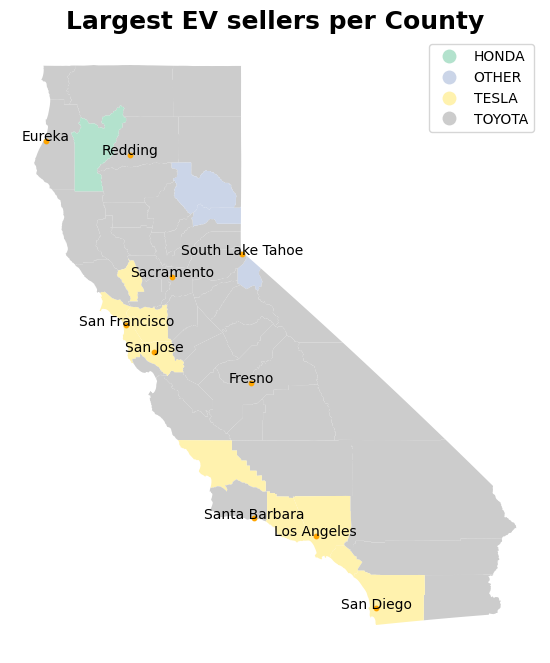

In [139]:
# Plot
# Who sells the most EVs per county?

fig, ax = plt.subplots(figsize = (8, 8))
county_gdf.plot(ax=ax,
                categorical = True,
                column='largest_maker',
                legend = True,
                cmap = 'Pastel2')
cities.plot(ax=ax,
           color = 'orange',
           markersize = 10)

for idx, row in cities.iterrows():
    plt.annotate(text=row['city'], xy=row['coords'], horizontalalignment='center', color='Black')

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

for edge in ['right', 'bottom', 'top','left']:
    ax.spines[edge].set_visible(False)
    
ax.set_title('Largest EV sellers per County', size=18, weight='bold')